In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import time
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_CAL_IMAGES = os.path.join(BASE_DIR, "02_prepared_data/cal/images")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")
DIR_TEST_IMAGES = DIR_CAL_IMAGES.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


0it [00:00, ?it/s]

252it [00:00, 798.66it/s] 


In [10]:
test_pred_probas, test_res_emb, test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

546it [00:00, 834.76it/s] 


In [11]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]


In [12]:
cal_res_emb = np.concatenate([np.ones((cal_res_emb.shape[0], 1)), cal_res_emb], axis=1)
test_res_emb = np.concatenate([np.ones((test_res_emb.shape[0], 1)), test_res_emb], axis=1)

RESNET_EMBEDDING_SIZE += 1

In [13]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

# Fit CRC

In [14]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [15]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
mapie_crc.lambdas = np.arange(0, 1, 0.001)
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 252/252 [00:04<00:00, 52.35it/s]


In [16]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.276])

In [17]:
mapie_crc.risks.shape

(252, 1000)

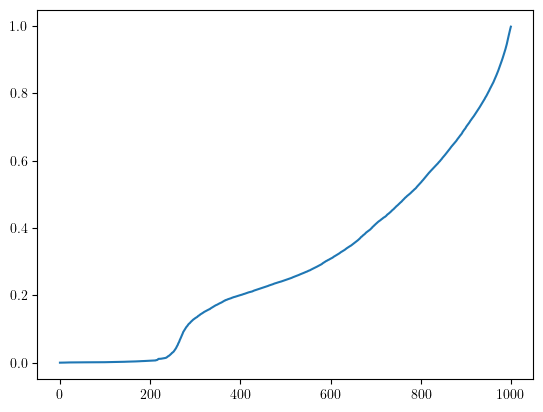

In [18]:
plt.plot(mapie_crc.risks.mean(axis=0))

# Fit multi-accurate with ResNet embedding

In [19]:
lambda_resnet = .01
result_res = minimize(
    J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULARIZATION, lambda_resnet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_res = (test_res_emb @ result_res.x).reshape(-1, 1, 1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.629059832695235
            Iterations: 39
            Function evaluations: 92
            Gradient evaluations: 39


# Apply thresholds on pred-probas

In [20]:
y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

In [21]:
precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
precision_test_crc =(y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


/tmp/ipykernel_4134426/1638778521.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)


# Plot results

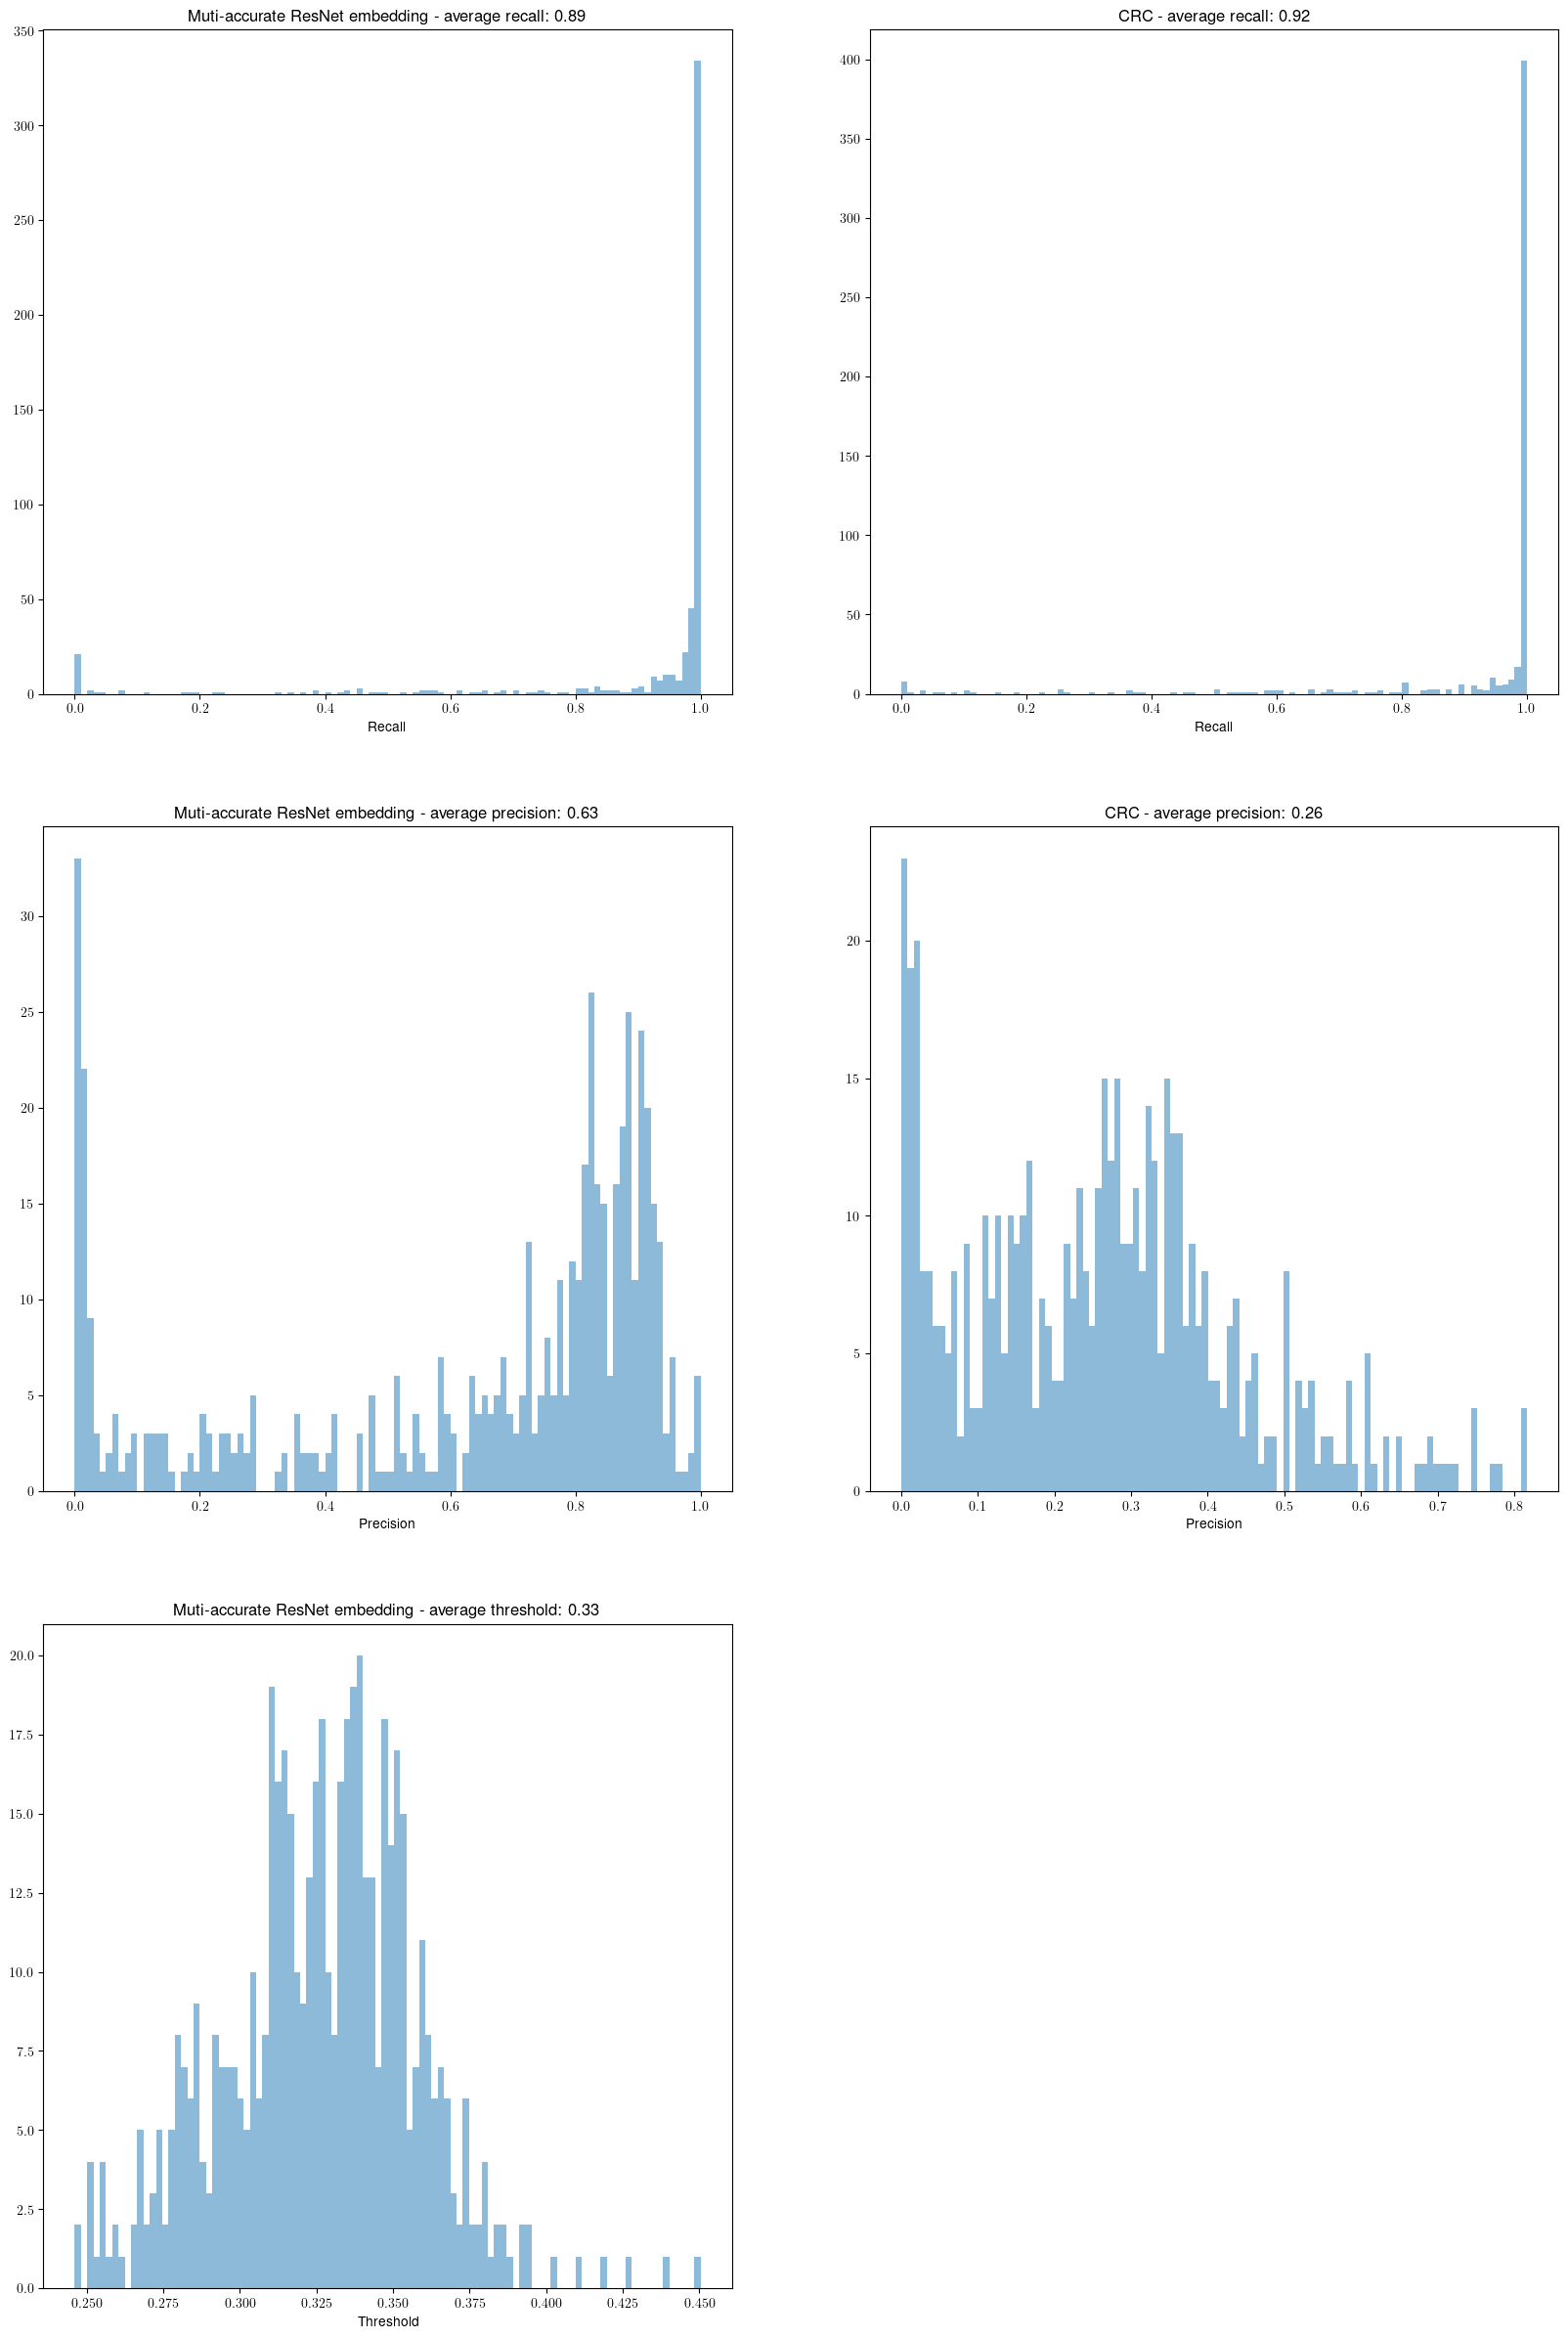

In [22]:
s = 10
nrow = 3
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

ax[0, 0].hist(recall_resnet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recall_resnet):.2f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.2f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precision_test_resnet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precision_test_resnet):.2f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.2f}")
ax[1, 1].set_xlabel("Precision")


ax[2, 0].hist(ths_res[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate ResNet embedding - average threshold: {np.nanmean(ths_res):.2f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].set_axis_off()